In [1]:
using Catlab
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.Programs
using Catlab.Graphics
using Catlab.Graphics: Graphviz

using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using AlgebraicDynamics.UWDDynam
using AlgebraicDynamics.CPortGraphDynam
using AlgebraicDynamics.CPortGraphDynam: grid

using LabelledArrays

using DynamicalSystems, OrdinaryDiffEq
using Plots
plotly()
using PyPlot

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots C:\Users\mgatlin3\.julia\packages\Plots\QaOSg\src\backends.jl:372


In [2]:
# Pick a composition syntax

W = 10; H = 1  # we'll create a grid with width 10 and height 1

# initialize the instance
stencil = OpenCPortGraph()

# add the boxes
boxes = reshape(add_parts!(stencil, :Box, W*H), H, W) 

ports = map(i -> add_parts!(stencil, :Port, 4,  box = i), boxes)

# add up/down wires
map(view(boxes, 1:(H - 1), 1:W)) do b
    add_part!(stencil, :Wire, src = ports[b][3], tgt = ports[b + 1][1])
    add_part!(stencil, :Wire, tgt = ports[b][3], src = ports[b + 1][1])
end

# add left/right wires
map(view(boxes, 1:H, 1:(W-1))) do b
    add_part!(stencil, :Wire, src = ports[b][2], tgt = ports[b+H][4])
    add_part!(stencil, :Wire, tgt = ports[b][2], src = ports[b+H][4])
end

# add outer ports
add_parts!(stencil, :OuterPort, W, con = map(i -> ports[1,i][1], 1:W))
add_parts!(stencil, :OuterPort, W, con = map(i -> ports[H,i][3], 1:W))
add_parts!(stencil, :OuterPort, H, con = map(i -> ports[i,1][4], 1:H))
add_parts!(stencil, :OuterPort, H, con = map(i -> ports[i,W][2], 1:H))

# stencil



22:22

In [4]:
c = CPortGraph();
migrate!(c, stencil);

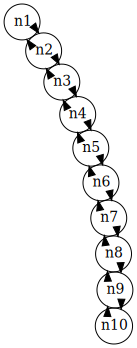

In [5]:
to_graphviz(c)

In [6]:
# # Choose a primitive model. We will fill each box with the same primitive model
# # We are attempting to encode the elastic curvature of a beam when presented with a load on the free end
# # Via trial and error the order of ports appears to be as follows
# #
# #                 1
# #                 |
# #            2---------4
# #                 |
# #                 3

point_model = DiscreteMachine{Float64}(
    4, # number of inputs, (x(left, right, top, bottom))
    2, # number of states, x(i), y(i)
    4, # number of outputs
    # dynamics: u - the state vector (current node), x - the input vector (neighbors)
    (u,x,p,t) -> [u[1], -1*(p.γ*((u[1])^2)*(3*p.L-u[1]))*(((p.γ*((x[4])^2)*(3*p.L-x[4])) - 
                (p.γ*((u[1])^2)*(3*p.L-u[1]))) /
                (x[4]-u[1]))], # displacement, u(x,y)
    u -> collect(repeat([u[1]], 4)) # the read out function, for each machine 
)


DiscreteMachine(ℝ^2 × ℝ^4 → ℝ^2)

In [57]:
# g(u,x,p) = (p.γ*((x[4])^2)*(3*p.L-x[4]))

# f(u,x,p,t) = begin
#     du = [
#         -1*(0.5)*((g(u,x,p) -
#         (p.γ*((u[1])^2)*(3*p.L-u[1]))) /
#         (x[4]-u[1]))
#    ]
#     return du
# end

# point_model = DiscreteMachine{Float64}(
#     4, # number of inputs, (x(left, right, top, bottom))
#     1, # number of states, x(i)
#     4, # number of outputs
#     # dynamics: u - the state vector (current node), x - the input vector (neighbors)
#     f,
#     u -> repeat(u, 4) # the read out function, for each machine
# )

In [58]:
# Equations I want to encode:
# v(i) = Px^2/6EI (3L-x)
# θ(i) = dv/dx
# u(i) = -y * θ(i) 
# ϵ(i) = -y* du/dx
# sigma(x) = ϵ(i) * E


In [10]:
# Compose!
# Apply the point model to each box of the stencil
displacement_eq = oapply(stencil, point_model)


LoadError: MethodError: no method matching euler_approx(::DiscreteMachine{Float64})
[0mClosest candidates are:
[0m  euler_approx([91m::ContinuousResourceSharer{T}[39m) where T at C:\Users\mgatlin3\.julia\packages\AlgebraicDynamics\s46pf\src\uwd_dynam.jl:94
[0m  euler_approx([91m::ContinuousResourceSharer{T}[39m, [91m::Float64[39m) where T at C:\Users\mgatlin3\.julia\packages\AlgebraicDynamics\s46pf\src\uwd_dynam.jl:84
[0m  euler_approx([91m::Array{ContinuousResourceSharer{T}, 1}[39m, [91m::Any...[39m) where T at C:\Users\mgatlin3\.julia\packages\AlgebraicDynamics\s46pf\src\uwd_dynam.jl:100
[0m  ...

In [8]:
# Solve and plot!

# initial coundition
a = Any[1., 0., 2., 0., 3., 0.,4., 0., 5., 0., 6., 0., 7., 0., 8., 0., 9., 0., 10., 0.] #(x_0,y_0)
u0 = convert(Array{Float64,1}, a) 


# boundary condition
xs = Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
xs = convert(Array{Float64,1}, xs)


# parameters
P = 9e6; # load, N
E = 5e6 # Young's modulus, N/m^2
I = 1/12 # second moment of area, m^4

length = 10 # beam length, m
gamma = P/(6*E*I) # just used to collect all the constants in one variable aside from length

params = LVector(γ = gamma, L = length)
nsteps = 25


# find the trajectory
traj = trajectory(displacement_eq, u0, xs, params, nsteps)

displacement = traj[:, 2:2:end];  # even matrix containing displacements

displacement
# Plots.spy(Matrix(traj), legend = nothing)

# matshow(Matrix(traj))
# #save plot as PNG
# png("C:\\Users\mgatlin3\GitHub\AlgebraicDynamics.jl\notebooks\matshow_traj")

10-dimensional Dataset{Float64} with 26 points
      0.0   0.0         0.0        …   0.0        0.0         0.0
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5  …  -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5  …  -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  -4.12556e5     -5.1276e6  -6.45917e6  -7.75008e6
 -10899.4  -1.20476e5  

In [64]:
Plots.plot(displacement[:2], label = "first timestep", linewidth=3)

xlabel!("longitudinal beam axis")
ylabel!("beam displacement")

<!DOCTYPE html>
 
 
 Plots.jl